# Hierarchical Agent Teams

In our previous example ([Agent Supervisor](../agent_supervisor)), we introduced the concept of a single [supervisor node](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#supervisor) to route work between different worker nodes.

But what if the job for a single worker becomes too complex? What if the number of workers becomes too large?

For some applications, the system may be more effective if work is distributed _hierarchically_.

You can do this by composing different subgraphs and creating a top-level supervisor, along with mid-level supervisors.

To do this, let's build a simple research assistant! The graph will look something like the following:

![diagram](attachment:50a6ed47-ace3-428e-8dcf-a13ec56c11d6.png)

This notebook is inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al. In the rest of this notebook, you will:

1. Define the agents' tools to access the web and write files
2. Define some utilities to help create the graph and agents
3. Create and define each team (web research + doc writing)
4. Compose everything together.

## Setup

First, let's install our required packages and set our API keys

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain langchain_openai langchain_experimental nltk langchain_community langchain_experimental langchain_core

In [2]:
pip install -U langchain langchain-openai

Note: you may need to restart the kernel to use updated packages.


In [3]:
from dotenv import load_dotenv
load_dotenv()
import os

OPENAI_API_KEY=os.getenv('OPENAI_API_KEY')
TAVILY_API_KEY=os.getenv('TAVILY_API_KEY')

In [4]:
import yfinance as yf

yf.__version__

'0.2.50'

In [5]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5,include_images=True )

@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [6]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

from langchain_core.tools import tool, StructuredTool
from datetime import date

@tool
def company_information(ticker: str) -> dict:
    """Use this tool to retrieve company information like address, industry, sector, company officers, business summary, website,
       marketCap, current price, ebitda, total debt, total revenue, debt-to-equity, etc."""

    ticker_obj = yf.Ticker(ticker)
    ticker_info = ticker_obj.get_info()

    return ticker_info

@tool
def last_dividend_and_earnings_date(ticker: str) -> dict:
    """
    Use this tool to retrieve company's last dividend date and earnings release dates.
    It does not provide information about historical dividend yields.
    """
    ticker_obj = yf.Ticker(ticker)

    return ticker_obj.get_calendar()

@tool
def summary_of_mutual_fund_holders(ticker: str) -> dict:
    """
    Use this tool to retrieve company's top mutual fund holders.
    It also returns their percentage of share, stock count and value of holdings.
    """
    ticker_obj = yf.Ticker(ticker)
    mf_holders = ticker_obj.get_mutualfund_holders()

    return mf_holders.to_dict(orient="records")

@tool
def summary_of_institutional_holders(ticker: str) -> dict:
    """
    Use this tool to retrieve company's top institutional holders.
    It also returns their percentage of share, stock count and value of holdings.
    """
    ticker_obj = yf.Ticker(ticker)
    inst_holders = ticker_obj.get_institutional_holders()

    return inst_holders.to_dict(orient="records")

@tool
def stock_grade_updrages_downgrades(ticker: str) -> dict:
    """
    Use this to retrieve grade ratings upgrades and downgrades details of particular stock.
    It'll provide name of firms along with 'To Grade' and 'From Grade' details. Grade date is also provided.
    """
    ticker_obj = yf.Ticker(ticker)

    curr_year = date.today().year

    upgrades_downgrades = ticker_obj.get_upgrades_downgrades()
    upgrades_downgrades = upgrades_downgrades.loc[upgrades_downgrades.index > f"{curr_year}-01-01"]
    upgrades_downgrades = upgrades_downgrades[upgrades_downgrades["Action"].isin(["up", "down"])]

    return upgrades_downgrades.to_dict(orient="records")

@tool
def stock_splits_history(ticker: str) -> dict:
    """
    Use this tool to retrieve company's historical stock splits data.
    """
    ticker_obj = yf.Ticker(ticker)
    hist_splits = ticker_obj.get_splits()

    return hist_splits.to_dict()

@tool
def stock_news(ticker: str) -> dict:
    """
    Use this to retrieve latest news articles discussing particular stock ticker.
    """
    ticker_obj = yf.Ticker(ticker)

    return ticker_obj.get_news()


#stock_news_tool = StructuredTool.from_function(stock_news)

In [7]:
from typing import List, Optional
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph, START
from langchain_core.messages import HumanMessage, trim_messages

llm = ChatOpenAI(model="gpt-4o-mini")
from langchain_community.chat_models import ChatPerplexity
llm_perplexity = ChatPerplexity(model="llama-3.1-sonar-small-128k-online")

trimmer = trim_messages(
    max_tokens=100000,
    strategy="last",
    token_counter=llm,
    include_system=True,
)


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }


def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | trimmer
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )
    
tools = [
         company_information,
         last_dividend_and_earnings_date,
         stock_splits_history,
         summary_of_mutual_fund_holders,
         summary_of_institutional_holders,
         stock_grade_updrages_downgrades,
         stock_news
]

In [8]:
import functools
import operator

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent


# ResearchTeam graph state
class ResearchTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str


search_agent = create_react_agent(llm, tools=[tavily_tool])
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

research_agent = create_react_agent(llm, tools=[scrape_webpages])
research_node = functools.partial(agent_node, agent=research_agent, name="WebScraper")

writer_agent = create_react_agent(llm, tools=tools,state_modifier= "Imagine you are a cryptocurrency analyst and are a specialist on Ethereum Ecosystem. Can you perform an analysis of the information provided below? Please, structure like an article, with heading and subheadings, divided into paragraphs. Take the writing style of Matt Levine but the intellectual understanding of John Authers, another Bloomberg writer. Make sure the analysis adopts a tone that is conversational, engaging, and accessible, while still retaining the depth of the financial insights.")
writer_node = functools.partial(agent_node, agent=writer_agent, name="Writer")

supervisor_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, WebScraper and Writer. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Search", "WebScraper", "Writer"],
)

C:\Users\rios1\AppData\Local\Temp\ipykernel_23232\2553010698.py:62: LangChainDeprecationWarning: The method `BaseChatOpenAI.bind_functions` was deprecated in langchain-openai 0.2.1 and will be removed in 1.0.0. Use :meth:`~langchain_openai.chat_models.base.ChatOpenAI.bind_tools` instead.
  | llm.bind_functions(functions=[function_def], function_call="route")


In [9]:
research_graph = StateGraph(ResearchTeamState)
research_graph.add_node("Search", search_node)
research_graph.add_node("WebScraper", research_node)
research_graph.add_node("supervisor", supervisor_agent)
research_graph.add_node("Writer", writer_node)

# Define the control flow
research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("WebScraper", "supervisor")
research_graph.add_edge("Writer", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "WebScraper": "WebScraper", "Writer": "Writer", "FINISH": END},
)


research_graph.add_edge(START, "supervisor")
chain = research_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results


research_chain = enter_chain | chain

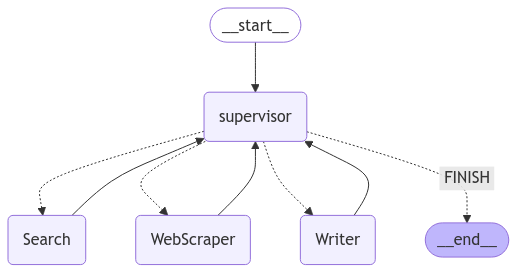

In [10]:
from IPython.display import Image, display

display(Image(chain.get_graph(xray=True).draw_mermaid_png()))

We can give this team work directly. Try it out below.

In [11]:
for s in research_chain.stream(
    """ 
“Analyze the price of bitcoin the last 3 years”

    """, {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

AuthenticationError: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-************************************************************************************************************************powA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}

In [20]:
for s in research_chain.stream(
    "Analyze the price of bitcoin the last 3 years",
    {"recursion_limit": 100}):
    
    if "__end__" not in s:
        output_messages = []
        output_messages.append(s)
# Si hay resultados, procesarlos
    if output_messages:
        for output_message in output_messages:
            classifiers = output_message.get('Writer', {})
            for valor in classifiers.values():
                for idx, elemento in enumerate(valor, start=1):
                   print(elemento.content)


# Analyzing Bitcoin's Price Journey: 2021-2023

Bitcoin, the granddaddy of cryptocurrencies, has had quite the rollercoaster ride over the past three years. From sky-high peaks to gut-wrenching lows, and now a remarkable resurgence, it’s a fascinating saga that reflects broader market sentiments, economic conditions, and technological shifts. Let’s break down this journey in a way that’s not only digestible but engaging.

## 1. The Wild Ride of 2021

### **A Meteoric Rise**
The year 2021 kicked off with Bitcoin hovering around the $29,000 mark. By April, it rocketed to an astronomical high of approximately **$64,800**. What fueled this meteoric rise? Well, a cocktail of institutional adoption, massive retail interest, and a sprinkle of FOMO (Fear of Missing Out) among investors. The buzz around Bitcoin as a hedge against inflation also played a pivotal role.

### **The Cliff Dive**
However, as we all know, what goes up must come down. After reaching its peak, Bitcoin entered a phase of